<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/07_%5BNLP%5D_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: word2vec and skip-gram**

| | |
|------|------|
| Filename | 07_[NLP]_word2vec.ipynb |
| Author(s) | Benjamin (contact.upside830@silomails.com) |
| Date | January 26, 2024 |
| Aim(s) | build a word embedding space with the skip-gram method |
| Dataset(s) | IMDb Movie Reviews dataset [[1]](https://aclanthology.org/P11-1015.pdf)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
* **Step 1.** Fill in the inputs.
* **Step 2.** GPU execution is recommended for training. Yet, a pre-trained model can be used by running this notebook on a CPU. Using a pre-trained model saves time, computer resources and CO2 emissions.
* **Step 3.** Run all and read comments.

---

#### **Motivation**

With the IMDb dataset used in code [02_classfication_text.ipynb](https://github.com/Benjamin-morel/TensorFlow/tree/main), the model is trained using a word2vec technique and model's weights are then used to construct a word embedding space.  

#### **Outline**

*   Input section
*   Python librairies & display utilities
*   Data retrieval & set generation
*   Embedding word space construction
*   Classification model & training
*   Embedding space exploration
*   References

---

## **0. Input section**

In [1]:
max_features = 5000
max_length = 20


---

## **1. Python librairies & display utilities**

In [2]:
# @title 1.1. Python librairies [RUN ME]

"""math"""
import numpy as np # linear algebra
import sklearn.metrics # scores and evaluation metrics

"""file opening and pre-processing"""
import os # miscellaneous operating system interfaces
import pandas as pd # data manipulation tool
from re import escape # regular expressions
import string # string manipulation
import shutil # operations on files

"""ML models"""
import tensorflow as tf # framework for ML/DL
from tensorflow import keras # API used to build model in TensorFlow

"""display and export"""
import matplotlib.pyplot as plt # graphing package
import pickle # serialization

"""performances"""
from time import time # timer
start = time()
device = tf.config.list_physical_devices(device_type=None)[-1][-1]

In [3]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and imports the files required (see section 3.2)"""
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_model = 'TensorFlow_duplicata/99_pre_trained_models/07_word2vec/07_word2vec.keras'
  path_classifier = 'TensorFlow_duplicata/99_pre_trained_models/07_word2vec/07_classification_text.keras'
  path_dictionary = 'TensorFlow_duplicata/99_pre_trained_models/07_word2vec/dictionary_embedding.pkl'
  path_vocab = 'TensorFlow_duplicata/99_pre_trained_models/07_word2vec/vocab.pkl'
  path_word_list = 'TensorFlow_duplicata/99_pre_trained_models/07_word2vec/word_list'

  model = keras.models.load_model(path_model, custom_objects={'Word2Vec': Word2Vec})
  classifier = keras.models.load_model(path_classifier)
  with open(path_dictionary, 'rb') as f:
    dictionary = pickle.load(f)
  with open(path_vocab, 'rb') as f:
    vocab = pickle.load(f)
  with open(path_word_list, 'rb') as fp:
    word_list = pickle.load(fp)

  !rm -rf TensorFlow_duplicata/
  return model, dictionary, vocab, classifier, word_list

In [4]:
# @title 1.3. Figure plots [RUN ME]

"""plot confusion matrix and ROC curve"""
def plot_evaluation(test_dataset, predictions, labels=[0,1]):
  actuals = tf.concat([y for x, y in test_dataset], axis=0)
  predicted_labels = np.round(predictions, 0)

  plt.figure(figsize=(12,5))

  confusion_mat = tf.math.confusion_matrix(actuals,predicted_labels) # columns = prediction labels / rows = real labels

  # Subplot 1: Confusion matrix
  plt.subplot(1,2,1, xlabel="Predictions", ylabel="Actuals", title="Confusion matrix of the test set", xticks=[0,1], yticks=[0,1])
  plt.imshow(confusion_mat)

  for i in range(confusion_mat.shape[0]): # annotation in each cnfusion matrix cell
      for j in range(confusion_mat.shape[1]):
          plt.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')

  # Subplot 2: ROC curve
  fpr, tpr, _ = sklearn.metrics.roc_curve(actuals,  predictions.ravel())
  plt.subplot(1,2,2, xlabel="FPR", ylabel="TPR", title="ROC curve")
  plt.plot(fpr, tpr)

  # Metrics info
  accuracy = sklearn.metrics.accuracy_score(actuals, predicted_labels)
  recall = sklearn.metrics.recall_score(actuals, predicted_labels)
  F1_score = sklearn.metrics.f1_score(actuals, predicted_labels)

  print("############################")
  print("Evaluation on the test set: ")
  print("############################")
  print("Accuracy...{:.4f}" .format(accuracy))
  print("Recall.....{:.4f}" .format(recall))
  print("F1-score...{:.4f}" .format(F1_score))

  plt.show()

---


## **2. Data retrieval and set generation**

The skip-gram method is a word embedding technique used in Word2Vec to learn vector representations of words based on their surrounding context. It works by selecting a target word and predicting its context words within a given window size.

>Example: "This horror movie was so terrifying that I screamed!"

>Window = 1<br>
>Target word: "terrifying": "This horror movie was [**so terrifying that**] I screamed!" <br>
>Context words: "so" and "that"

With a larger window to capture more context:

>Window = 3 <br>
>Target word: "terrifying": "This horror [**movie was so terrifying that I screamed**]!" <br>
>Context words: "movie", "was", "so", "that", "I" and "screamed"

Each word is converted to an integer and passed through a neural network with a single hidden layer. The model is trained to maximize the probability of context words given the target word, often using negative sampling to improve efficiency.

After training, the hidden layer weights form a word embeddings space, where words are represented by a 16-dimensional embedding vector. Skip-gram is especially useful for capturing relationships between words.


### 2.1. Retrieve data

The IMDb Movie Reviews is a database created for sentiment analysis in movie reviews. It contains 50,000 movie reviews. The database is extracted and placed in the folder review_dataset. The architecture of review_dataset is as follows:

```markdown
**Imdb_dataset/**
. . . aclImdb/
. . . . . . train/
. . . . . . test/
. . . . . . README
. . . . . . imdb.vocab
. . . . . . imdbEr.text
```

Other files are included in the folder like `README` which provides information about the dataset and how to use it. Files `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations.

To train the model, the labels used to classify are not required.

In [5]:
def get_data(url, batch_size):

  dataset_name = "Imdb_dataset_1"
  path = tf.keras.utils.get_file(dataset_name, url, extract=True)
  path = os.path.join(path, 'aclImdb')
  train_path = os.path.join(path, 'train')
  test_path = os.path.join(path, 'test')
  remove_dir = os.path.join(train_path, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
  shutil.rmtree(remove_dir)

  # data used to build embedding word space with the skip-gram method
  data_skip_gram = tf.keras.utils.text_dataset_from_directory(train_path, labels=None, batch_size=batch_size, validation_split=None, shuffle=True, seed=1, verbose=0)

  # data for classification model (same as 02_classification_text.ipynb)
  raw_train_ds = keras.utils.text_dataset_from_directory(train_path, batch_size=32, validation_split=0.2, subset='training', shuffle=True, seed=1)
  raw_val_ds = keras.utils.text_dataset_from_directory(train_path, batch_size=32, validation_split=0.2, subset='validation', shuffle=True, seed=1)
  raw_test_ds = keras.utils.text_dataset_from_directory(test_path, batch_size=32)

  return data_skip_gram, raw_train_ds, raw_val_ds, raw_test_ds

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

batch_size = 1

all_texts, raw_train_ds, raw_val_ds, raw_test_ds = get_data(url, batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


The batch size is 1 to facilitate pre-processing of texts. The variable `nb_text` is used to control the number of texts to be supplied to the model.



In [7]:
for text in all_texts.take(1):
  print("Here, an example of text data used for the skip-gram method: \n", text.numpy())

Here, an example of text data used for the skip-gram method: 
 [b'"Dressed to Kill" is Brian DePalma\'s best film, an absolute thrill ride of suspense, humor and style that remains unrivaled today. DePalma has a bum rap in Hollywood, as most people claim that he rips off Alfred Hitchcock. He does not. Hitchcock could only dream of what DePalma shows in his thrillers.<br /><br />Sadly, the original uncut version of "Dressed to Kill" is no longer available on video. The current copy released by Goodtimes is the Jack Valenti approved R rated cut. But some copies of DePalma\'s original cut still exist. It is the one distributed by Warner Home Video, in both a green cardboard box with Angie Dickinson on the cover, or in a black clamshell case with the theatrical poster on silver lining. These are the ones to get, if you can find a copy. I have the green one and it is among my treasured possessions.<br /><br />Anyway, back to the story. Dickinson plays Kate Miller, a sexually frustrated wife

### 2.2. Pre-processing

Input data must be processed:
```markdown
Tensor(['The film was ....'])
Tensor(['I see this movie ...'])
. . .
```
Each tensor is composed of a sentence (and not an entire movie review). So, for one review, several tensors can be generated. It is assumed that each sentence carries a context/meaning. A sentence is defined here as a series of words ending by a `. `, a `? ` or a ' ! `.

In [8]:
if device == "GPU":
  punctuation_to_remove = escape(string.punctuation).replace('.', '').replace('?', '').replace('!', '')

The 50 most frequent words in the dataset are also removed. This list of words comes from the Jupyter Notebook [02_classfication_text.ipynb](https://github.com/Benjamin-morel/TensorFlow/tree/main). These words are removed because they carry a little meaning and increase the size of the model's input vectors:

```markdown
The dog barked loudly --> dog barked loudly --> ['dog', 'barked', 'loudly']
```

In [9]:
if device == "GPU":
  token_common = [' the ', ' and ', ' a ', ' of ', ' to ', ' is ', ' in ', ' it ', ' i ', ' this ', ' that ', ' br ', ' was ', ' as ', ' with ', ' for ',
                  ' you ', ' on ', ' are ', ' one ', ' be ', ' he ', ' its ', ' have ', ' an ', ' by ', ' at ', ' all ', ' from ', ' who ', ' so ',
                  ' they ', ' her ', ' just ', ' some ', ' out ', ' about ', ' or ', ' s ', ' if ', '  c  ', ' there ', ' were ', ' would ', ' had ', ' it ', ' we ']

In [10]:
def custom_standardization_for_skip_gram(input_text):
  text_modified = tf.strings.lower(input_text) # upper cases --> lower cases
  text_modified = tf.strings.regex_replace(text_modified, '<br />', ' ') # remove HTML strings
  for i in range(len(token_common)):
    text_modified = tf.strings.regex_replace(text_modified, token_common[i], ' ') # remove frequent words
  text_modified = tf.strings.regex_replace(text_modified, '[%s]' % punctuation_to_remove, '') # remove punctuation
  return text_modified

In [11]:
if device == "GPU":
  all_texts_processed = all_texts.map(lambda x: custom_standardization_for_skip_gram(x))
  for text in all_texts_processed.take(1):
    print("Here is the result of the transformation: \n", text.numpy())

An example of a pre-processed movie review is displayed. Only the punctuation elements `.`, `?` and `!` are retained.

From these pre-processed texts, the sentences are separated and isolated into tensors.

In [12]:
def split_sentences(text):
  text =  tf.strings.split(text, '. ')
  text =  tf.strings.split(text, '? ')
  text =  tf.strings.split(text, '! ')
  return text

In [13]:
if device == "GPU":
  all_texts_processed_sentences = all_texts_processed.map(lambda x: split_sentences(x))

Finally, the tensors contained in `train_ds` - with variable size - are converted into individual scalar tensors.

In [14]:
def split_ragged_tensor(ragged_tensor):
  flat_values = ragged_tensor.flat_values
  return tf.data.Dataset.from_tensor_slices(flat_values)

In [15]:
if device == "GPU":
  all_texts_processed_sentences = all_texts_processed_sentences.flat_map(split_ragged_tensor)
  for text in all_texts_processed_sentences.take(5):
    print(text.numpy())

### 2.3. Vectorization

A maximum of n tokens (default: 20) are generated for each sentence and then vectorized.

In [16]:
vectorize_layer = tf.keras.layers.TextVectorization(standardize=None, # already done
                                                    max_tokens=max_features,
                                                    output_mode='int',
                                                    output_sequence_length=max_length)

In [17]:
if device == "GPU":
  vectorize_layer.adapt(all_texts_processed_sentences.batch(batch_size=1024))
  skip_gram_data = all_texts_processed_sentences.map(vectorize_layer)

In [18]:
if device == "GPU":
  word_list = vectorize_layer.get_vocabulary()
  int_list = list(skip_gram_data.as_numpy_iterator())

  with open("word_list", "wb") as fp:   #Pickling
    pickle.dump(word_list, fp)

  for seq in int_list[:5]:
    print(f"{seq} => {[word_list[i] for i in seq]}")

---


## **3. Embedding word space construction**

### 3.1. Skip-gram pair generation

Generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) based on window size, number of negative samples and vocabulary size.

In [19]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  targets, contexts, labels = [], [], []

  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size) # Build the sampling table for `vocab_size` tokens.

  for sequence in sequences: # Iterate over all sequences (sentences) in the dataset

    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(sequence,
                                                                       vocabulary_size=vocab_size,
                                                                       sampling_table=sampling_table,
                                                                       window_size=window_size,
                                                                       negative_samples=0) # Generate positive skip-gram pairs for a sequence (sentence)

    for target_word, context_word in positive_skip_grams: # Iterate over each positive skip-gram pair to produce training examples with a positive context word and negative samples.

      context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)

      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(true_classes=context_class,
                                                                                   num_true=1,
                                                                                   num_sampled=num_ns,
                                                                                   unique=True,
                                                                                   range_max=vocab_size,
                                                                                   seed=seed,
                                                                                   name="negative_sampling")


      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0) # Build context and label vectors (for one target word)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      targets.append(target_word) # Append each element from the training example to global lists.
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [20]:
if device == "GPU":
  targets, contexts, labels = generate_training_data(sequences=int_list,
                                                     window_size=2,
                                                     num_ns=4,
                                                     vocab_size=max_features,
                                                     seed=1)

  targets = np.array(targets)
  contexts = np.array(contexts)
  labels = np.array(labels)

  print(f"targets.shape: {targets.shape}")
  print(f"contexts.shape: {contexts.shape}")
  print(f"labels.shape: {labels.shape}")

### 3.2. Performances and batches

In [21]:
if device == "GPU":
  batch_size = 1024
  AUTOTUNE = tf.data.AUTOTUNE
  dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
  dataset = dataset.shuffle(len(targets)).batch(batch_size).repeat()

  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

### 3.3. Model definition

In [22]:
@keras.utils.register_keras_serializable()
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, **kwargs):
    super(Word2Vec, self).__init__()
    self.vocab_size = vocab_size # Store vocab_size as an attribute
    self.embedding_dim = embedding_dim # Store embedding_dim as an attribute
    self.target_embedding = tf.keras.layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

  def get_config(self): # Define get_config to include vocab_size and embedding_dim
    config = super(Word2Vec, self).get_config()
    config.update({"vocab_size": self.vocab_size, "embedding_dim": self.embedding_dim})
    return config

  @classmethod
  def from_config(cls, config): # Define from_config to use vocab_size and embedding_dim
      return cls(**config)

In [23]:
def create_model(embedding_dim):
  model = Word2Vec(max_features, embedding_dim)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=None)
  return model

### 3.4. Training phase

In [24]:
def train_model(model, training_data, steps_per_epoch, **kwargs):
  kwargs.setdefault("epochs", 15)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, steps_per_epoch = steps_per_epoch, **kwargs)

  return log.history["loss"]

In [25]:
if device == "GPU":
  model = create_model(16)
  steps_per_epoch = len(targets) // batch_size
  history = train_model(model, dataset, steps_per_epoch)
  model.save('07_word2vec.keras')
else:
  model, dictionary_embedding, vocab, classifier_model, word_list = get_github_files()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 888, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 888 (delta 180), reused 136 (delta 136), pack-reused 698 (from 3)
Receiving objects: 100% (888/888), 194.49 MiB | 31.92 MiB/s, done.
Resolving deltas: 100% (450/450), done.


---


## **4. Classification model and training**

### 4.1. Pre-processing layer for classification model

In [26]:
weights = model.get_layer('w2v_embedding').get_weights()[0]

In [27]:
@keras.utils.register_keras_serializable()
def custom_standardization_classification(input_text):
  no_uppercase = tf.strings.lower(input_text) # upper case --> lower case letters
  no_html_uppercase = tf.strings.regex_replace(no_uppercase, '<br />', ' ') # remove HTML strings
  no_punctuation_html_uppercase = tf.strings.regex_replace(no_html_uppercase, '[%s]' % escape(string.punctuation), '') # remove punctuation
  return no_punctuation_html_uppercase

In [28]:
raw_train_ds = raw_train_ds.map(lambda x, y: (custom_standardization_classification(x), y))
raw_test_ds = raw_test_ds.map(lambda x, y: (custom_standardization_classification(x), y))
raw_val_ds = raw_val_ds.map(lambda x, y: (custom_standardization_classification(x), y))

In [29]:
max_length = 500 # truncate to the 500th word

vectorize_layer1 = keras.layers.TextVectorization(standardize=None,
                                                 max_tokens=max_features,
                                                 output_sequence_length=max_length,
                                                 output_mode='int',
                                                 vocabulary = word_list
                                                 )

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 4.2. Classification model

In [31]:
custom_embedding_layer = keras.Sequential([keras.layers.Embedding(input_dim = max_features, output_dim = 16, embeddings_initializer=keras.initializers.Constant(weights))])

In [32]:
custom_embedding_layer.trainable = False

In [33]:
def create_classifier():
  embedding_dim = 16
  model = keras.Sequential([vectorize_layer1, # pre-processing layer
                            custom_embedding_layer,
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(16, activation='relu'),
                            keras.layers.GlobalAveragePooling1D(),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1, activation='sigmoid')
                            ], name="classification_text_model")

  model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)])

  return model

In [34]:
def train_classifier(model, training_data, validation_data, callbacks, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, callbacks=callbacks, **kwargs)

  return log.history["loss"], log.history["binary_accuracy"], log.history["val_loss"], log.history["val_binary_accuracy"]

In [35]:
if device == "GPU":
  stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                            patience=20,
                                            restore_best_weights=True,
                                            min_delta=0.001)

In [36]:
if device == "GPU":
  epochs = 100
  classifier_model = create_classifier()
  classifier_accuracy = train_classifier(classifier_model, raw_train_ds, raw_val_ds, callbacks=stop_early, epochs=epochs)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))
  classifier_model.save('07_classification_text.keras')

### 4.3. Evaluation and predictions

In [37]:
def get_predictions(dataset):
  loss_test, accuracy_test = classifier_model.evaluate(dataset, verbose=0)
  predictions = classifier_model.predict(dataset, verbose=0)
  print("Test loss value %0.1f \nTest accuracy: %0.1f %%" %(loss_test, 100*accuracy_test))
  return predictions

In [38]:
predictions = get_predictions(raw_test_ds)

Test loss value 0.5 
Test accuracy: 80.2 %


############################
Evaluation on the test set: 
############################
Accuracy...0.8019
Recall.....0.8890
F1-score...0.8178


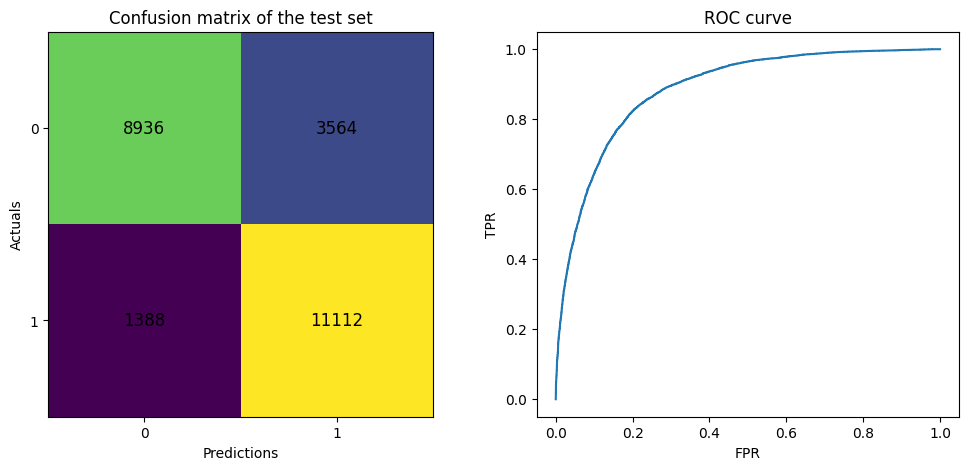

In [39]:
plot_evaluation(raw_test_ds, predictions)

---


## **5. Embedding space exploration**

### 5.1. Embedding dictionary

In [40]:
if device == "GPU":
  vocab = vectorize_layer.get_vocabulary()
  dictionary_embedding = {vocab[i]:weights[i] for i in range(len(vocab))} # build the embedding dictionary

  with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

  with open('dictionary_embedding.pkl', 'wb') as f:
    pickle.dump(dictionary_embedding, f)

In [41]:
dictionary_embedding["money"]

array([-0.4511153 , -0.1555667 , -0.16605273, -0.06758016,  0.32298324,
       -0.34737492, -0.2298189 , -0.04030469, -0.76292896,  0.18483113,
        0.1460447 , -0.1714578 , -0.37093538, -0.7198567 , -0.25342757,
        0.20178515], dtype=float32)

### 5.2. Similarities and analogies

In [42]:
# get the distance between two elements in the embedding space

def get_distance(token1, token2):
  p1 = dictionary_embedding[token1]
  p2 = dictionary_embedding[token2]
  distance = np.linalg.norm(p2-p1)
  return distance

# get the cosinus similarity between two elements in the embedding space

def get_cosinus_similarity(token1, token2):
  p1 = dictionary_embedding[token1]
  p2 = dictionary_embedding[token2]
  dot_product = np.dot(p1, p2)
  magnitude_1 = np.linalg.norm(p1)
  magnitude_2 = np.linalg.norm(p2)
  cosine_sim = dot_product / (magnitude_1 * magnitude_2)
  return cosine_sim

In [43]:
# get elements closest to a specific element in the embedding space

def get_synomym(token, n, used_distance=True):
  p1 = dictionary_embedding[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, len(vocab)): # only the first 1000 words of the embedding dictionary are searched
    token_candidate = vocab[i]
    if used_distance == True: candidate_list[token_candidate] = get_distance(token, token_candidate)
    else: candidate_list[token_candidate] = get_cosinus_similarity(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  if used_distance == True: synonym_list = sorted_items[1:n+1]
  else: synonym_list = sorted_items[-(n+1):-1]
  words = [(item[0], item[1]) for item in synonym_list]
  return print(words)

In [44]:
word = "terrible"
nb = 10
get_synomym(word, nb, used_distance=False)

[('pointless', 0.8044394), ('ludicrous', 0.8148322), ('totally', 0.8178258), ('laughable', 0.8416559), ('appalling', 0.85137874), ('abysmal', 0.8675813), ('dreadful', 0.8718299), ('horrendous', 0.8805921), ('horrible', 0.90182066), ('awful', 0.9120636)]


In [45]:
def get_analogy(vector, n):
  candidate_list = {} # stores n synonyms
  for i in range(1, len(vocab)):
    token_candidate = vocab[i]
    vector_candidate = dictionary_embedding[token_candidate]
    candidate_list[token_candidate] = sum(abs(vector - vector_candidate))

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])
  synonym_list = sorted_items[0:n]
  words = [item[0] for item in synonym_list]
  print(words)

In [46]:
analogy = dictionary_embedding["funny"] - dictionary_embedding["nice"] + dictionary_embedding["terrible"]
get_analogy(analogy, 5)

['pointless', 'offensive', 'boring', 'depressing', 'terrible']


---


## **6. References**

| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://aclanthology.org/P11-1015.pdf) | IMDB dataset | Andrew L. Maas & al | dataset & paper | - |
|[[2]](https://www.tensorflow.org/tutorials/keras/text_classification) | Basic text classification | TensorFlow | dataset | - |
|[[3]](https://www.tensorflow.org/guide/data_performance) | Better performance with the tf.data API | TensorFlow | Tutoriels | - |
|[[4]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) | Word2Vec and GloVe Vectors | Toronto university | website | - |

In [47]:
print("Notebook run in %.1f seconds on %s" % ((time() - start), tf.config.list_physical_devices(device_type=None)[-1][-1]))

Notebook run in 64.0 seconds on CPU
